# DREAM EXPERIMENT: analysis of simulated events

Importing modules

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optim
import scipy.stats as stats

# filename (to read data)
fileName = '30degrees.txt'
directory = '../datasets/'
fileName = directory + fileName
fileNameNumbers = directory + '/July2/numbersP30.txt'

## Total energy losses in detectors

Loading data from `energies.txt`:

In [6]:
# loading data from simulation
energyBGO, energyScint1, energyScint2 = np.loadtxt(fileName, unpack=True, usecols=(1,2,3))
energies = [energyBGO, energyScint1, energyScint2]
numbersC, numbersS = np.loadtxt(fileNameNumbers, unpack=True, usecols=(0,2))

# remove energies = 0 and energies > 200 MeV from datasets
for set in energies:
    for value in set:
        if value==0 or value>0:
            set = np.setdiff1d(set, np.array([value]))

[energyBGO, energyScint1, energyScint2] = energies

# number of Monte Carlo events
numberofevents = len(energyBGO)
print("You have {0} data".format(numberofevents))

You have 1687 data


### BGO crystal
##### Landau-Vavilov Fit:
A good limit of the Landau distribution is the Moyal pdf:
$$ p(x) = \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{x-e^{-x}}{2} \right) $$

In [7]:
# Moyal distribution
def f(x,mean,form,normalization):
    return normalization*stats.moyal.pdf(form*(x-mean))

# exponential distribution
def exponential(x, alpha, beta): #extended
    return alpha*np.exp(-beta*x)

# Moyal distribution + exponential one
def g(x, mean, form, normalization, alpha):
    return f(x,mean,form,normalization) + alpha*np.exp(-alpha*x)

##### Landau fit of energy loss in BGO crystal:
Here we have Landau plus an exponential part. We use the first data (at low energies) to fit the exponential. Then we subtract this exponential function to the data and we should find the pure Landau distributio, so we can fit it.

In [8]:
# extrapolate data from histogram
nb = 75
bin_heights, bin_borders = np.histogram(energyBGO, bins=nb, density=False)

# errors
delta_bin_heights = []
for value in bin_heights: delta_bin_heights.append(np.sqrt(value)/len(energyBGO))
bin_heights, bin_borders = np.histogram(energyBGO, bins=nb, density=True)
bin_centers = bin_borders[:-1] + 0.5*np.diff(bin_borders)
bin_width = np.diff(bin_borders)
xerror = [bin_width[0]*0.5 for i in bin_centers]

# fit of the exponential funciton, using first 13 elements
initial_alpha, initial_beta = bin_heights[0], bin_heights[0]
x_coords = bin_centers[:9]
y_coords = bin_heights[:9]
[alphaBGO, betaBGO], covariance_alphabeta_BGO = optim.curve_fit(exponential,
        x_coords, y_coords, p0=[initial_alpha,initial_beta], bounds=[0, np.inf])

# I subtract the exponential function to the heights
new_heights = list(bin_heights - [exponential(val, alphaBGO, betaBGO) for val in bin_centers])
# fit of the Landau-Moyal function
# energy corresponing to maximum:
idx_maximum = new_heights.index(max(new_heights))
max_energy = bin_centers[idx_maximum]
# initial values of parameters and their limits:
initial_values = [max_energy,0.4,max(new_heights)]
lower_bounds = [0,0,0]
upper_bounds = [50, 10, np.inf]
[mean_energyBGO, form_BGO, normalization_BGO], covariance_BGO = optim.curve_fit(f,
        bin_centers, new_heights, p0=initial_values, bounds=[lower_bounds, upper_bounds])

# print results
print("Results of fit:\nmean energy = {0} +/- {1}".format(mean_energyBGO,covariance_BGO[0][0]))
print("Form factor = {0} +/- {1}".format(form_BGO,covariance_BGO[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_BGO,covariance_BGO[2][2]))
print("Alpha = {0} +/- {1}".format(alphaBGO,covariance_alphabeta_BGO[0][0]))
print("Beta = {0} +/- {1}".format(betaBGO,covariance_alphabeta_BGO[1][1]))

Results of fit:
mean energy = 22.404261377493654 +/- 0.0011576427194896382
Form factor = 0.5041575898946008 +/- 4.1092061736133796e-05
Normalization = 0.4021060063160852 +/- 1.724228654560019e-05
Alpha = 0.01699518970064615 +/- 1.8842776803448528e-06
Beta = 0.10627105091199185 +/- 0.0002338852819900221


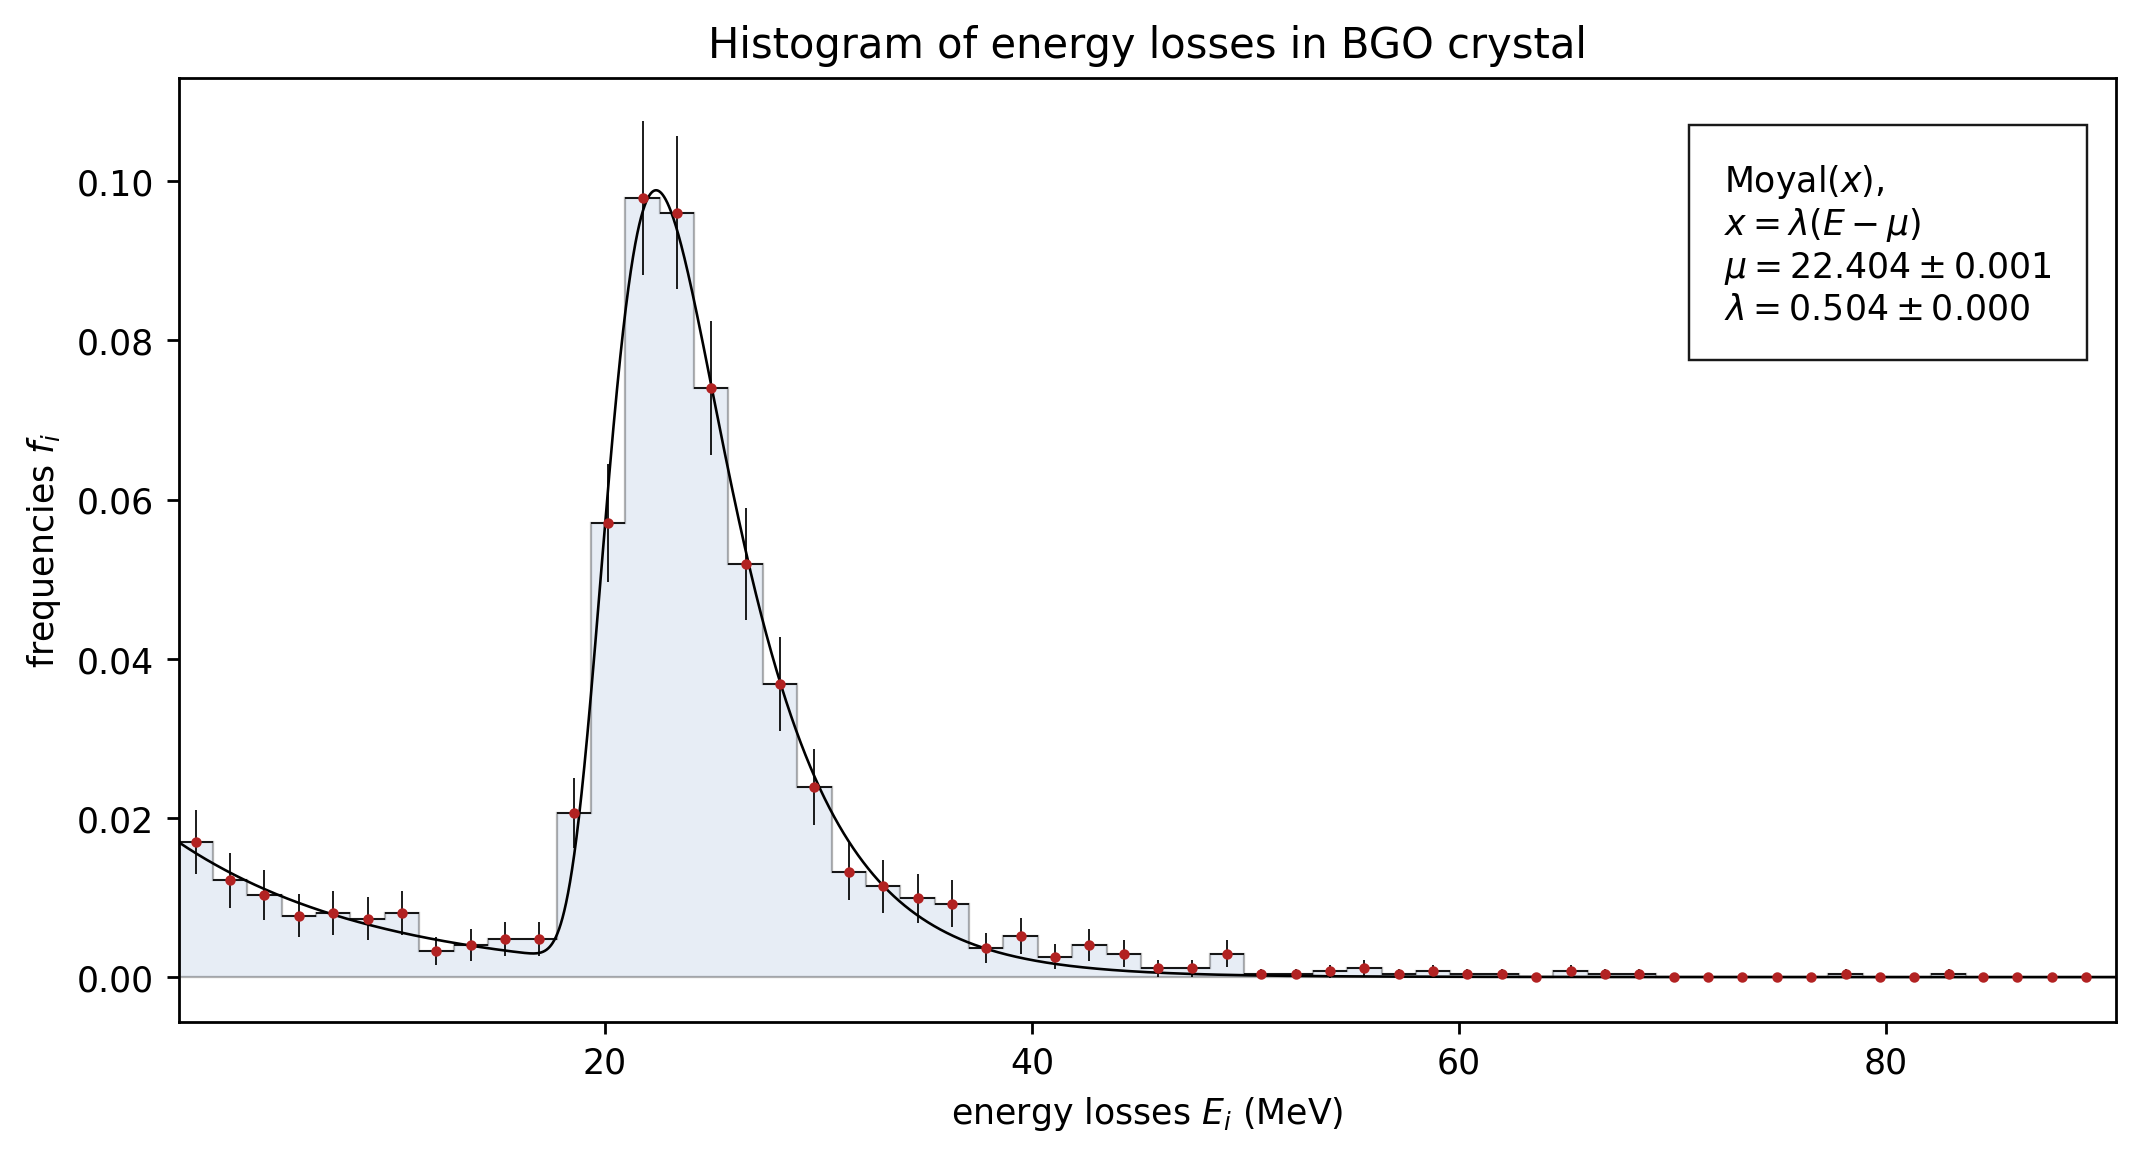

In [17]:
# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot the histo and relative points with errors
plt.hist(energyBGO, bins=nb, label='BGO crystal', histtype="stepfilled",
        color='lightsteelblue', ec='black', alpha=0.3, lw=0.65, density=True)
plt.errorbar(bin_centers, bin_heights, yerr=delta_bin_heights, xerr=xerror,
             marker='o', markersize=2, color="firebrick", ecolor="black", lw=0, elinewidth=0.5)

# prepare data to plot
energy_samples = np.arange(min(energyBGO), max(energyBGO), 0.0001)
landau_samples = f(energy_samples, mean_energyBGO, form_BGO, normalization_BGO) + exponential(energy_samples, alphaBGO, betaBGO)

# plot the fitted function
plt.plot(energy_samples, landau_samples, label='Landau distribution', lw=0.75, alpha=1, color="black")

# visualize
plt.title('Histogram of energy losses in BGO crystal')
plt.xlabel('energy losses $E_i$ (MeV)')
plt.xlim(min(energyBGO), max(energyBGO)-30)
plt.ylabel('frequencies $f_i$')
plt.text(min(energyBGO)+0.79*(max(energyBGO)-min(energyBGO))-23, max(bin_heights)*0.845,
         'Moyal$(x)$,\n$x = \lambda(E-\mu)$\n$\mu={0:.3f} \pm {1:.3f}$\n$\lambda = {2:.3f} \pm {3:.3f}$'.format(mean_energyBGO, covariance_BGO[0][0], form_BGO, covariance_BGO[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.show()
fig.savefig("LandauBGO.jpg",bbox_inches='tight')

### Plastic scintillators
Landau-Vavilov Fit: in this case there are some $\mu^-$ hitting the plastic scintillators in a little region of them (for geometrical reasons). This can be formally included in the analysis via a decreasing exponential function:
$$ f(E) = \beta e^{-\alpha E} $$
and, as a consequence: $$p(E) = f(E) + Moyal(E)$$

##### Fit:
we follow the same procedure of the case of BGO

In [18]:
# extrapolate data from histograms
number_bins = 25
bin_heights_1, bin_borders_1 = np.histogram(energyScint1, bins=number_bins, density=False)
delta_bin_heights_1 = []
for value in bin_heights_1: delta_bin_heights_1.append(np.sqrt(value))
bin_centers_1 = bin_borders_1[:-1] + 0.5*np.diff(bin_borders_1)
# array with binwidth
bin_width_1 = np.diff(bin_borders_1)
xerror1 = [bin_width_1[0]*0.5 for i in bin_centers_1]

bin_heights_2, bin_borders_2 = np.histogram(energyScint2, bins=number_bins, density=False)
delta_bin_heights_2 = []
for value in bin_heights_2: delta_bin_heights_2.append(np.sqrt(value))
bin_centers_2 = bin_borders_2[:-1] + 0.5*np.diff(bin_borders_2)
# array with binwidth
bin_width_2 = np.diff(bin_borders_2)
xerror2 = [bin_width_2[0]*0.5 for i in bin_centers_2]

# fit of the Landau-Moyal function:
# first a fit of the exponential function using first data
# then remove the exponential. At the end Moyal funciton fit
# 1
initial_alpha_1, initial_beta_1 = bin_heights_1[0], bin_heights_1[0]/len(energyScint1)
x_coords_1, y_coords_1 = bin_centers_1[:8], bin_heights_1[:8]
[alpha1, beta1], covariance_alphabeta_1 = optim.curve_fit(exponential,
        x_coords_1, y_coords_1, p0=[initial_alpha_1,initial_beta_1], bounds=[0, np.inf])
    # new heights
new_heights_1 = list(bin_heights_1 - [exponential(val, alpha1, beta1) for val in bin_centers_1])
idx_maximum_1 = new_heights_1.index(max(new_heights_1))
max_energy_1 = bin_centers_1[idx_maximum_1]
    # fit
[mean_energy1, form_1, normalization_1], covariance_1 = optim.curve_fit(f,
    bin_centers_1, bin_heights_1, p0=[20, 0.745, 0.6*len(energyScint2)])

# 2 
initial_alpha_2, initial_beta_2 = bin_heights_2[0], bin_heights_2[0]/len(energyScint2)
x_coords_2, y_coords_2 = bin_centers_2[1:10], bin_heights_2[1:10]
[alpha2, beta2], covariance_alphabeta_2 = optim.curve_fit(exponential,
        x_coords_2, y_coords_2, p0=[initial_alpha_2,initial_beta_2], bounds=[0, np.inf])
    # new heights
new_heights_2 = list(bin_heights_2 - [exponential(val, alpha2, beta2) for val in bin_centers_2])
idx_maximum_2 = new_heights_2.index(max(new_heights_2))
max_energy_2 = bin_centers_2[idx_maximum_2]
    # fit
[mean_energy2, form_2, normalization_2], covariance_2 = optim.curve_fit(f,
    bin_centers_2, bin_heights_2, p0=[20, 0.745, 0.6*len(energyScint2)]) 

# print results
print("Results of fit on plastic scintillator no. 1:\nmean energy = {0} +/- {1}".format(mean_energy1,covariance_1[0][0]))
print("Form factor = {0} +/- {1}".format(form_1,covariance_1[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_1,covariance_1[2][2]))
print("Alpha = {0} +/- {1}".format(alpha1,covariance_alphabeta_1[0][0]))
print("Beta = {0} +/- {1}".format(beta1,covariance_alphabeta_1[1][1]))
print("\nResults of fit on plastic scintillator no. 2:\nmean energy = {0} +/- {1}".format(mean_energy2,covariance_2[0][0]))
print("Form factor = {0} +/- {1}".format(form_2,covariance_2[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_2,covariance_2[2][2]))
print("Alpha = {0} +/- {1}".format(alpha2,covariance_alphabeta_2[0][0]))
print("Beta = {0} +/- {1}".format(beta2,covariance_alphabeta_2[1][1]))

Results of fit on plastic scintillator no. 1:
mean energy = 18.490130690073816 +/- 0.4774570891110043
Form factor = 0.8354688658250126 +/- 0.11904073064739348
Normalization = 1058.0078109557082 +/- 141250.61401149878
Alpha = 285.2155815676538 +/- 489.1079683069887
Beta = 0.11942095938549357 +/- 0.00022845720831557367

Results of fit on plastic scintillator no. 2:
mean energy = 18.38136018620546 +/- 0.8078628847217564
Form factor = 0.7854708506586512 +/- 0.15022380447782796
Normalization = 665.9619756759212 +/- 75352.69806363666
Alpha = 258.6296353201254 +/- 385.92174161094715
Beta = 0.15124655565221332 +/- 0.00021035975760690288


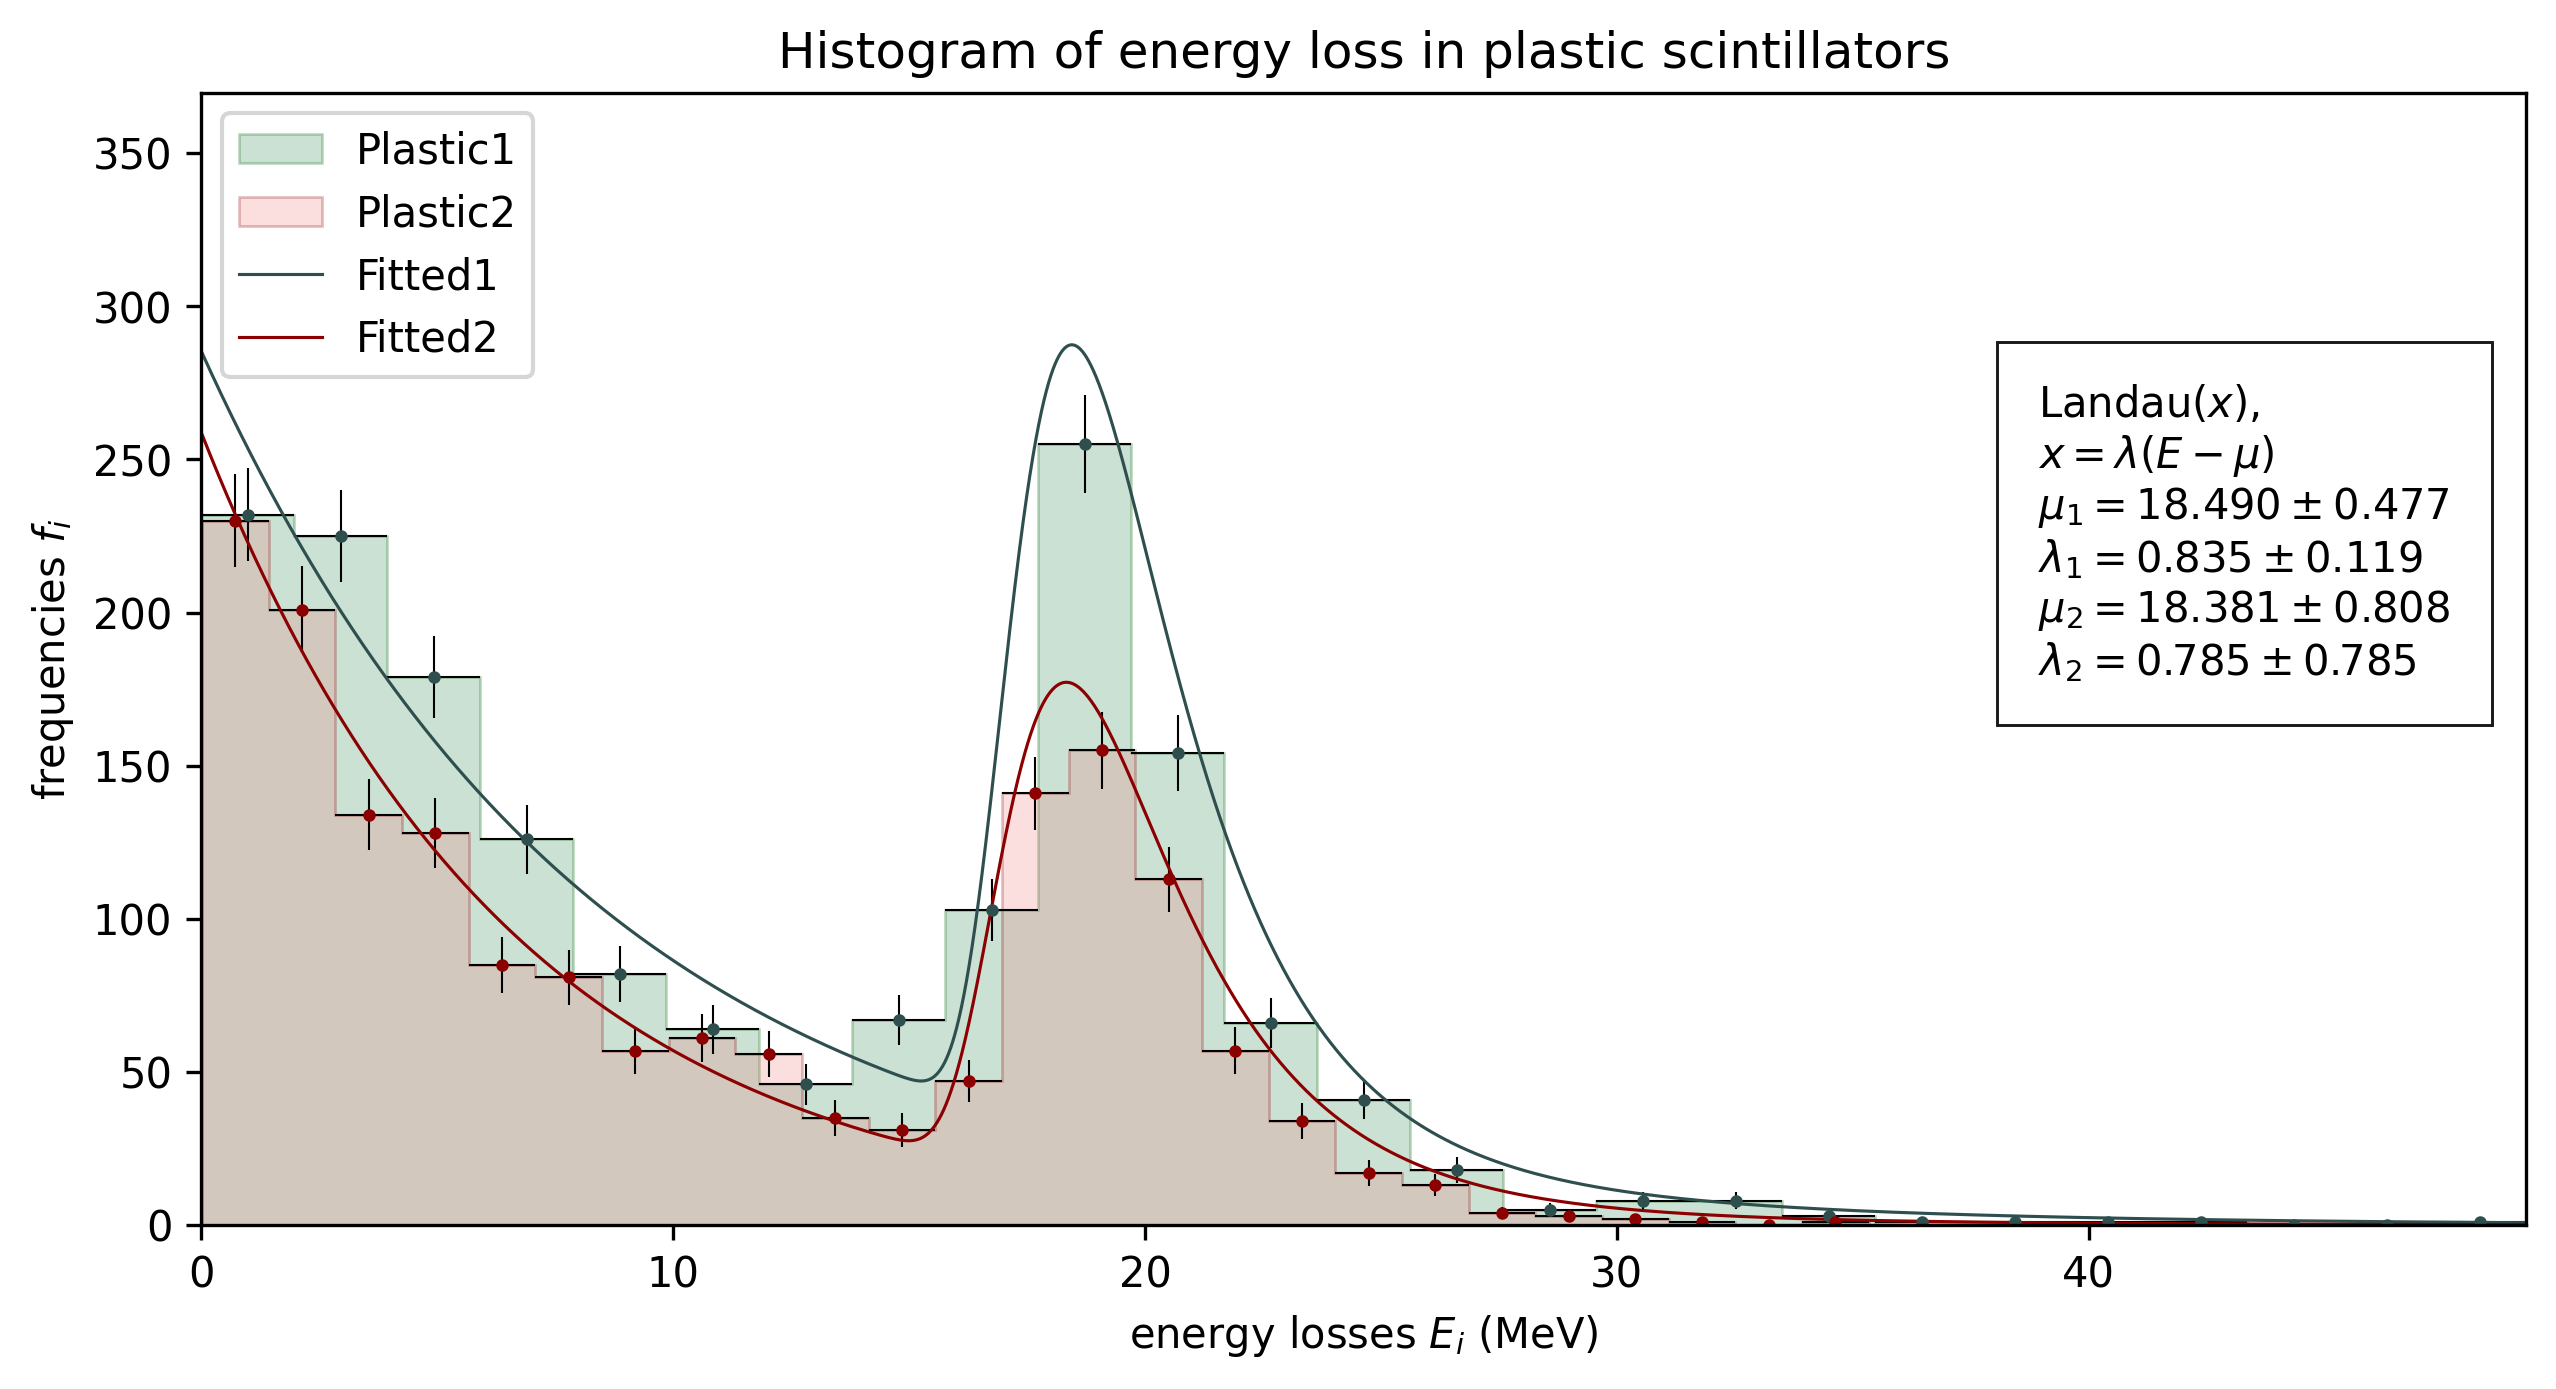

In [19]:
# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=300)

# plot the histos
plt.hist(energyScint1, bins=number_bins, label='Plastic1', histtype="stepfilled",
         color="seagreen", ec="darkgreen", alpha=0.25, lw=0.65, density=False)
plt.hist(energyScint2, bins=number_bins, label='Plastic2', histtype="stepfilled",
         color="lightcoral", ec="darkred", alpha=0.25, lw=0.65, density=False)

# histos + errorbars
plt.errorbar(bin_centers_1, bin_heights_1, yerr=delta_bin_heights_1, xerr=xerror1,
             marker='o', markersize=2, color="darkslategrey", ecolor="black", lw=0, elinewidth=0.5)
plt.errorbar(bin_centers_2, bin_heights_2, yerr=delta_bin_heights_2, xerr=xerror2,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)

# prepare data to plot
energy_samplesP = np.arange( min(min(energyScint1),min(energyScint2)), max(max(energyScint1),max(energyScint2)), 0.0001)
landauExp_samples1 = f(energy_samplesP, mean_energy1, form_1, normalization_1) + exponential(energy_samplesP, alpha1, beta1)
landauExp_samples2 = f(energy_samplesP, mean_energy2, form_2, normalization_2) + exponential(energy_samplesP, alpha2, beta2)

# plot the fitted function
plt.plot(energy_samplesP, landauExp_samples1, label= 'Fitted1', lw=0.75, alpha=1, color="darkslategrey")
plt.plot(energy_samplesP, landauExp_samples2, label= 'Fitted2', lw=0.75, alpha=1, color="darkred")

# visualize
plt.title('Histogram of energy loss in plastic scintillators')
plt.xlabel('energy losses $E_i$ (MeV)')
plt.ylabel('frequencies $f_i$')
plt.xlim(0,max(max(energyScint1),max(energyScint2)))
plt.ylim(0,max(max(bin_heights_1),max(bin_heights_2))*1.45)
plt.text(min(energyScint1)+0.79*(max(energyScint1)-min(energyScint1)), max(max(bin_heights_1),max(bin_heights_2))*0.705,
         'Landau$(x)$,\n$x = \lambda(E-\mu)$\n$\mu_1={0:.3f} \pm {1:.3f}$\n$\lambda_1 = {2:.3f} \pm {3:.3f}$\n$\mu_2={4:.3f} \pm {5:.3f}$\n$\lambda_2 = {6:.3f} \pm {6:.3f}$'.format(
             mean_energy1, covariance_1[0][0], form_1, covariance_1[1][1],mean_energy2, covariance_2[0][0], form_2, covariance_2[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.legend(loc='upper left')
plt.show()
fig.savefig("LandauPlastics.jpg",bbox_inches='tight')

#### Unified plot

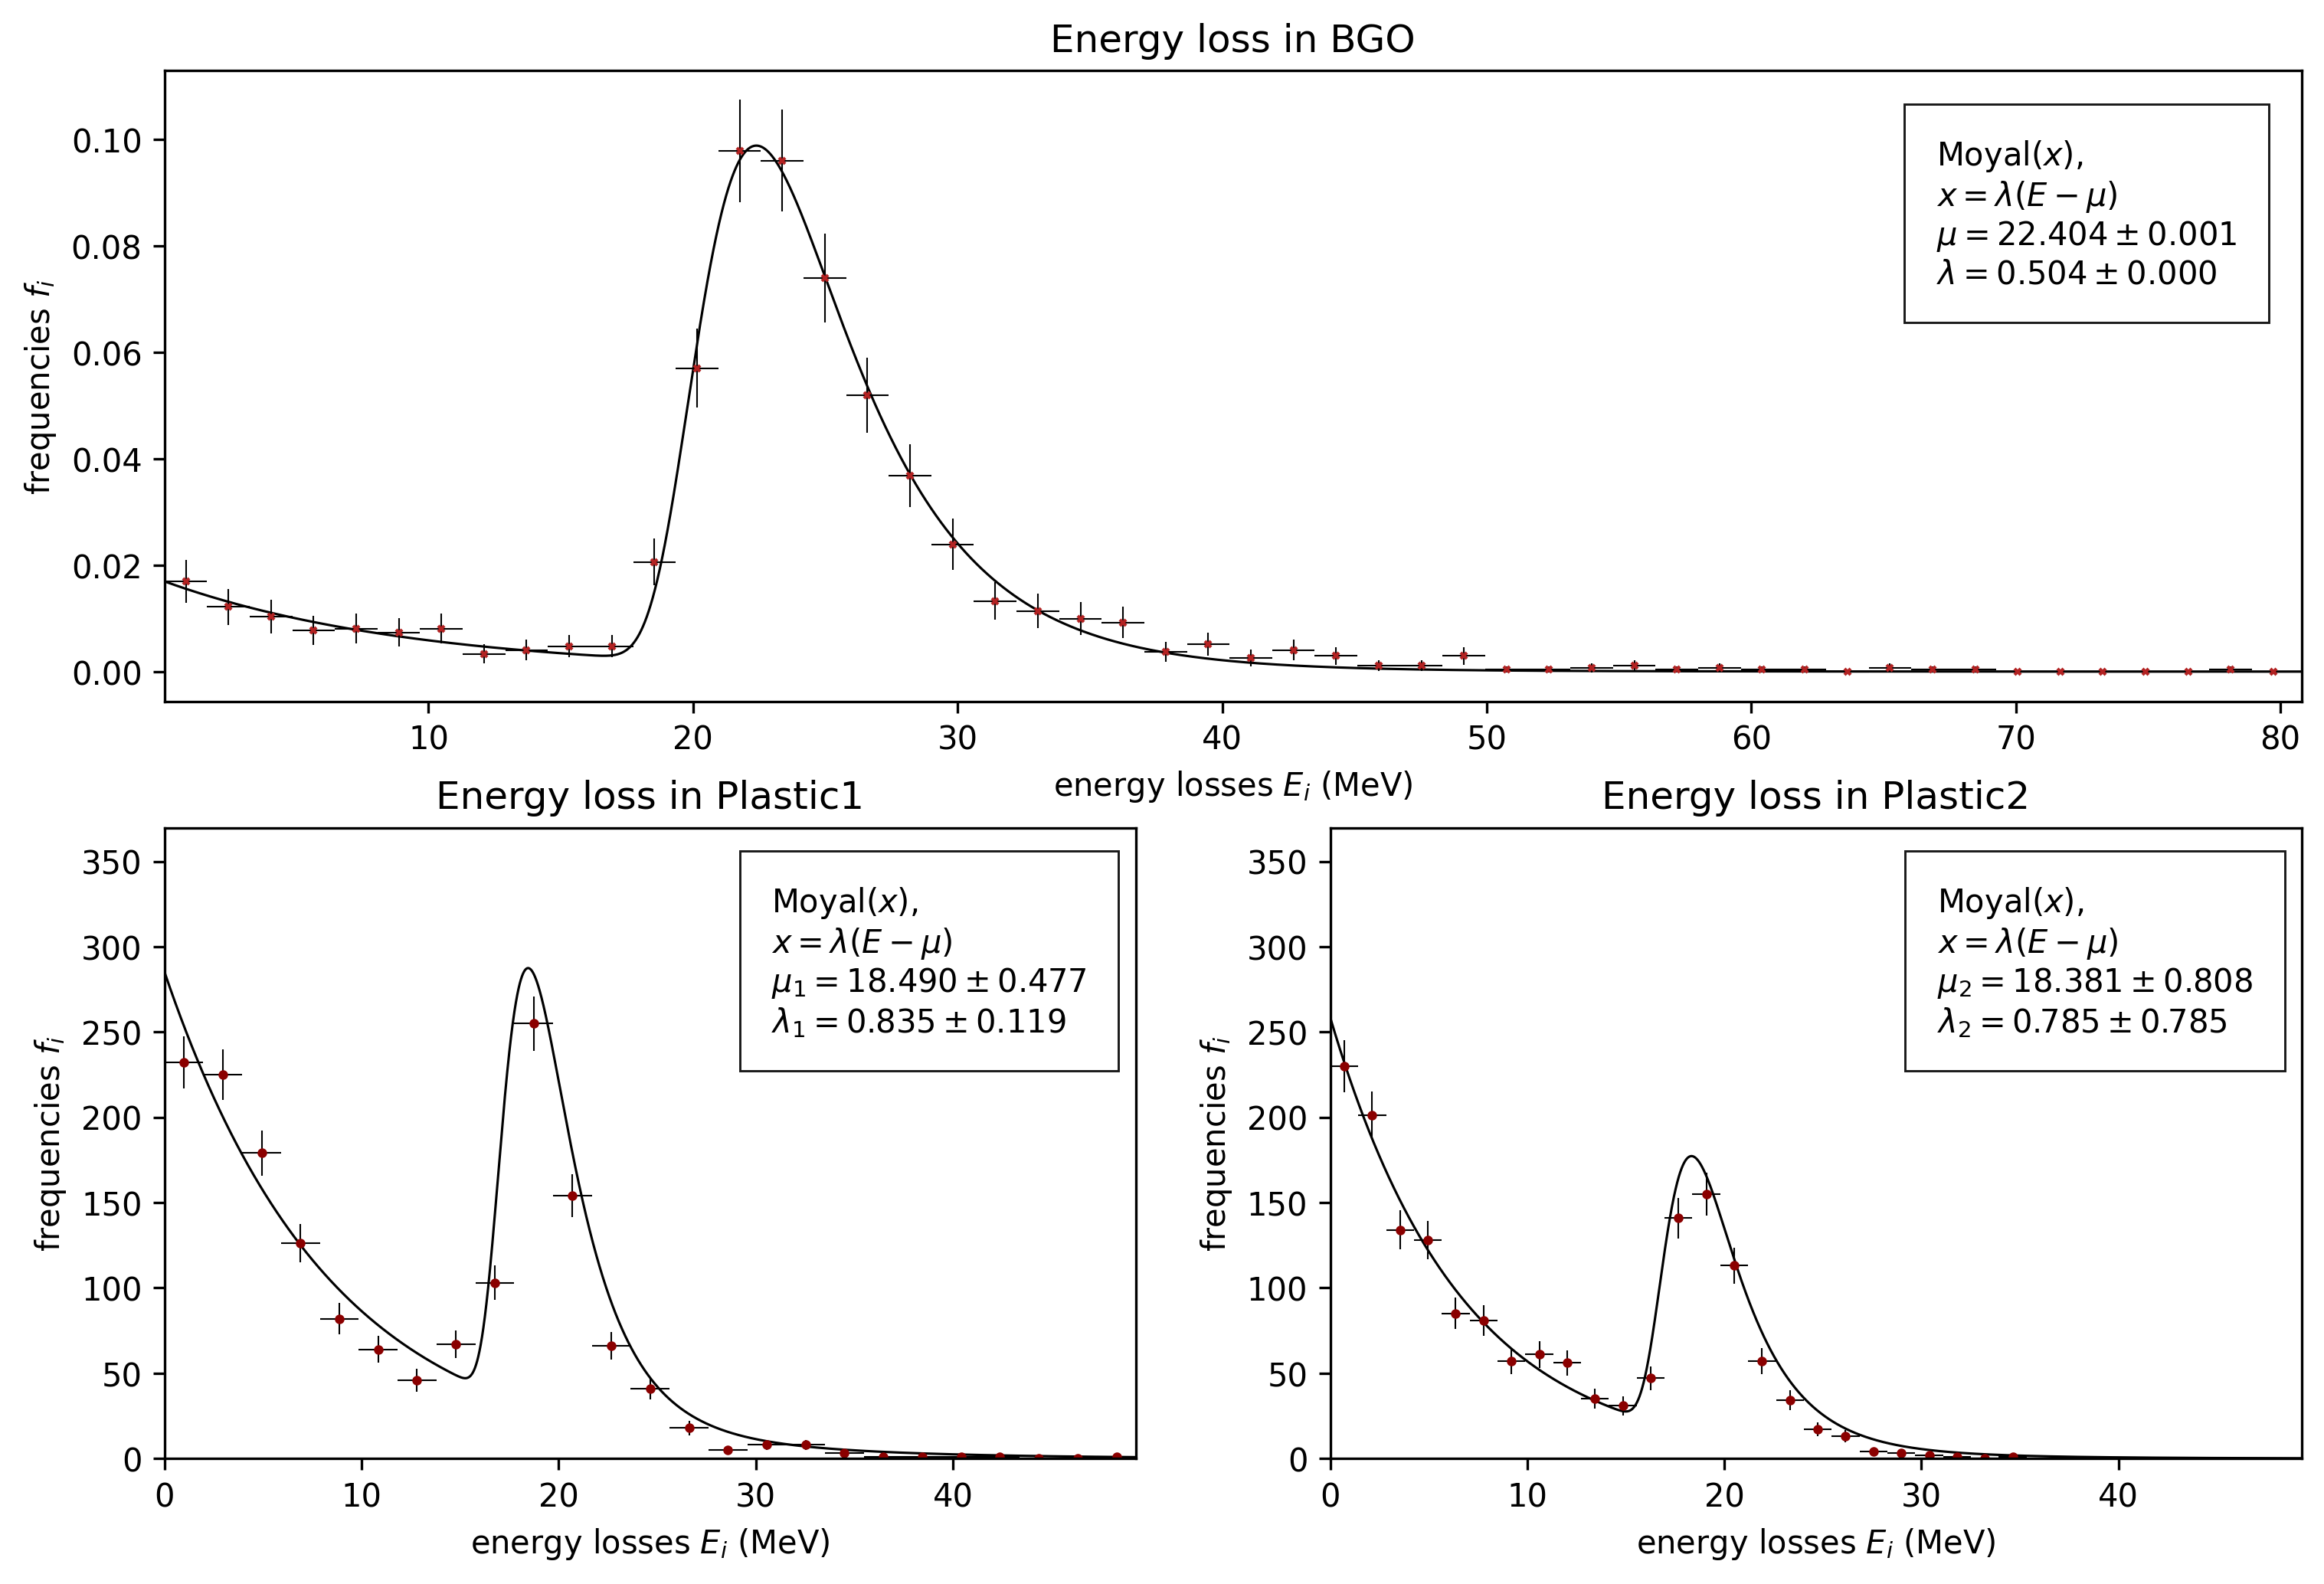

In [20]:
# prepare the figure
fig = plt.figure(111, figsize=(12,8), dpi=300)

# BGO energy loss
ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    # plot the histo and relative points with errors
#ax0.hist(energyBGO, bins=nb, label='BGO crystal', histtype="stepfilled",
#        color='lightsteelblue', ec='black', alpha=0.3, lw=0.65, density=True)
ax0.errorbar(bin_centers, bin_heights, yerr=delta_bin_heights, xerr=xerror,
             marker='x', markersize=2, color="firebrick", ecolor="black", lw=0, elinewidth=0.5)
    # plot the fitted function
ax0.plot(energy_samples, landau_samples, label='Landau distribution', lw=0.75, alpha=1, color="black")
plt.title("Energy loss in BGO")
plt.xlabel('energy losses $E_i$ (MeV)')
plt.ylabel('frequencies $f_i$')
plt.xlim(min(energyBGO), max(energyBGO)-40)
plt.text(min(energyBGO)+0.745*(max(energyBGO)-min(energyBGO))-23, max(bin_heights)*0.745,
         'Moyal$(x)$,\n$x = \lambda(E-\mu)$\n$\mu={0:.3f} \pm {1:.3f}$\n$\lambda = {2:.3f} \pm {3:.3f}$'.format(mean_energyBGO, covariance_BGO[0][0], form_BGO, covariance_BGO[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})

# Plastic scintillator 1
ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
#ax1.hist(energyScint1, bins=number_bins, label='Plastic1', histtype="stepfilled",
#         color="seagreen", ec="darkgreen", alpha=0.25, lw=0.65, density=True)
ax1.errorbar(bin_centers_1, bin_heights_1, yerr=delta_bin_heights_1, xerr=xerror1,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)
ax1.plot(energy_samplesP, landauExp_samples1, label= 'Fitted1', lw=0.75, alpha=1, color="black")
plt.title("Energy loss in Plastic1")
plt.xlabel('energy losses $E_i$ (MeV)')
plt.ylabel('frequencies $f_i$')
plt.xlim(0,max(max(energyScint1),max(energyScint2)))
plt.ylim(0,max(max(bin_heights_1),max(bin_heights_2))*1.45)
plt.text(min(energyScint1)+0.625*(max(energyScint1)-min(energyScint1)), max(max(bin_heights_1),max(bin_heights_2))*0.98,
         'Moyal$(x)$,\n$x = \lambda(E-\mu)$\n$\mu_1={0:.3f} \pm {1:.3f}$\n$\lambda_1 = {2:.3f} \pm {3:.3f}$'.format(
             mean_energy1, covariance_1[0][0], form_1, covariance_1[1][1],mean_energy2, covariance_2[0][0], form_2, covariance_2[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})

# Plastic scintillator 2
ax2 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
#ax2.hist(energyScint2, bins=number_bins, label='Plastic2', histtype="stepfilled",
#         color="lightcoral", ec="darkred", alpha=0.25, lw=0.65, density=True)
ax2.errorbar(bin_centers_2, bin_heights_2, yerr=delta_bin_heights_2, xerr=xerror2,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)
ax2.plot(energy_samplesP, landauExp_samples2, label= 'Fitted2', lw=0.75, alpha=1, color="black")
plt.title("Energy loss in Plastic2")
plt.xlabel('energy losses $E_i$ (MeV)')
plt.ylabel('frequencies $f_i$')
plt.xlim(0,max(max(energyScint1),max(energyScint2)))
plt.ylim(0,max(max(bin_heights_1),max(bin_heights_2))*1.45)
plt.text(min(energyScint1)+0.625*(max(energyScint1)-min(energyScint1)), max(max(bin_heights_1),max(bin_heights_2))*0.98,
         'Moyal$(x)$,\n$x = \lambda(E-\mu)$\n$\mu_2={4:.3f} \pm {5:.3f}$\n$\lambda_2 = {6:.3f} \pm {6:.3f}$'.format(
             mean_energy1, covariance_1[0][0], form_1, covariance_1[1][1],mean_energy2, covariance_2[0][0], form_2, covariance_2[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})

# end
plt.show()
fig.savefig("Unified.jpg",bbox_inches='tight')

## <span style="color:lightskyblue">Cherenkov</span> vs. <span style="color:khaki">scintillation</span> data analysis

##### Landau-Vavilov Fit + exponential decay:
A good limit of the Landau distribution is the Moyal pdf:
$$ p(x) = \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{x-e^{-x}}{2} \right) $$
For geometrical reasons, there are some $\mu^-$ hitting the crystal scintillators in a little region of it. This can be formally included in the analysis via a decreasing exponential function:
$$ f(E) = \alpha e^{-\alpha E} $$
and, as a consequence: $$p(E) = f(E) + Moyal(E)$$

In [23]:
# Moyal distribution + parameters
def f(x,mean,form,normalization):
    return normalization*stats.moyal.pdf(form*(x-mean))

# Moyal distribution + exponential one
def g(x, mean, form, normalization, alpha):
    return normalization*stats.moyal.pdf(form*(x-mean)) + alpha*np.exp(-alpha*x)

#### Fit of both Cherenkov and Scintillation distributions:

In [25]:
#SCINTILLATION LIGHT FIT
nbins = 45
# extrapolate data from histogram
bin_heightsScintillation, bin_bordersScintillation = np.histogram(numbersS, bins=nbins, density=False)
bin_centersScintillation = bin_bordersScintillation[:-1] + 0.5*np.diff(bin_bordersScintillation)

bin_heightsScintillation = list(bin_heightsScintillation)
idx_maximum = bin_heightsScintillation.index(max(bin_heightsScintillation))
max_numberS = bin_centersScintillation[idx_maximum]
[mean_energyScintillation, form_Scintillation, normalization_Scintillation], covariance_Scintillation = optim.curve_fit(f, bin_centersScintillation[1:], bin_heightsScintillation[1:], p0=[max_numberS, 0.10, max(bin_heightsScintillation)])

# print results
print('\nSCINTILLATION:')
print("Results of fit:\nmode in energy = {0} +/- {1}".format(mean_energyScintillation,covariance_Scintillation[0][0]))
print("Form factor = {0} +/- {1}".format(form_Scintillation,covariance_Scintillation[1][1]))
print("Normalization = {0} +/- {1}".format(normalization_Scintillation,covariance_Scintillation[2][2]))


SCINTILLATION:
Results of fit:
mode in energy = 3710.777777777778 +/- inf
Form factor = 0.1 +/- inf
Normalization = 57.858238612927494 +/- inf


Plot:

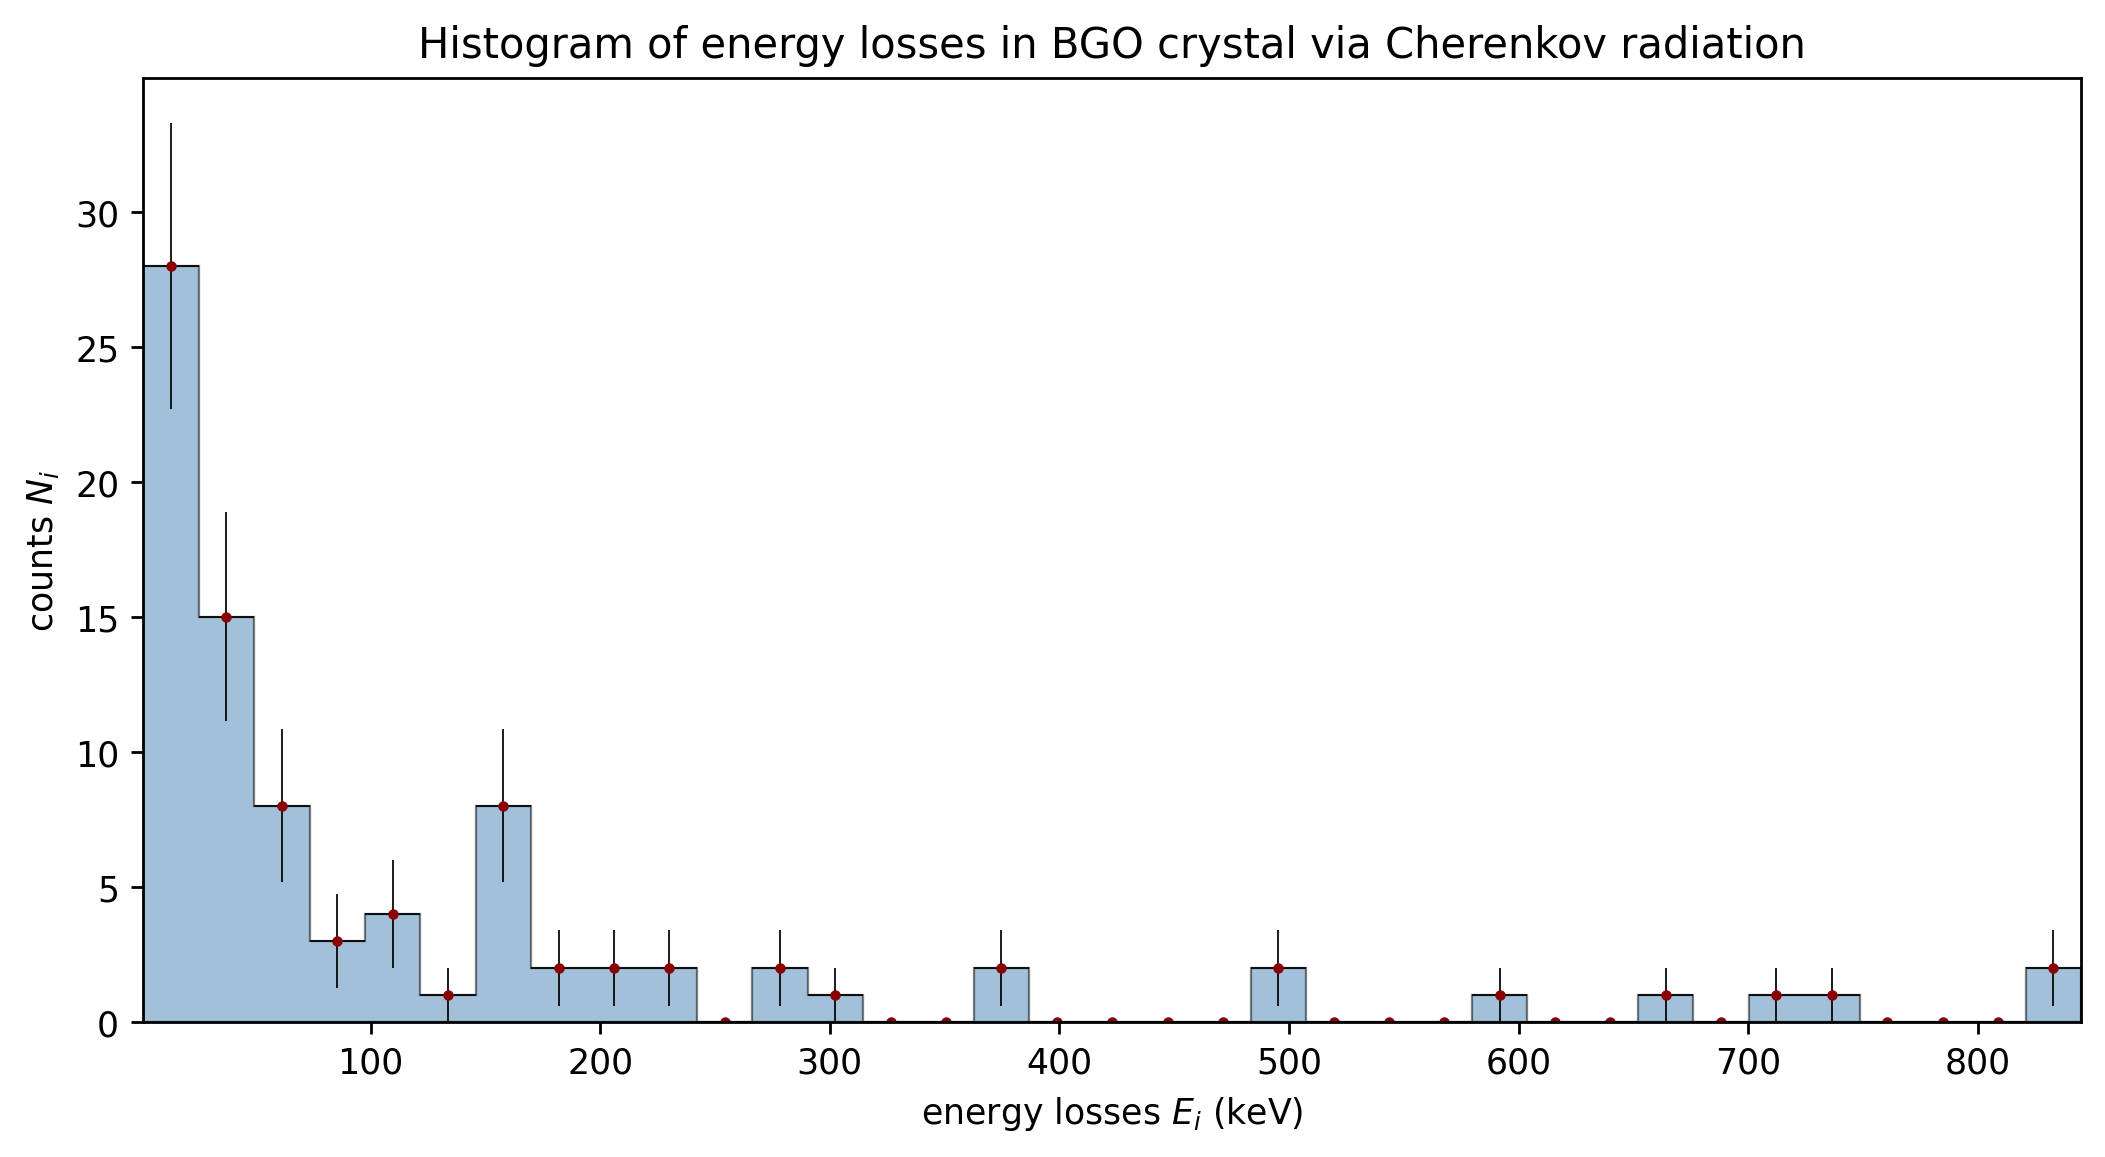

In [31]:
nbinsC = 35
bin_heightsC, bin_bordersC = np.histogram(numbersC, bins=nbinsC, density=False)
# errors
delta_bin_heightsC = []
for value in bin_heightsC: delta_bin_heightsC.append(np.sqrt(value))
bin_heightsC, bin_bordersC = np.histogram(numbersC, bins=nbinsC, density=False)
bin_centersC = bin_bordersC[:-1] + 0.5*np.diff(bin_bordersC)
bin_widthC = np.diff(bin_bordersC)
xerrorC = [bin_widthC[0]*0.5 for i in bin_centersC]
# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot the histo
plt.hist(numbersC, bins=nbinsC, label='BGO crystal', histtype="stepfilled",
        color='steelblue', ec='black', alpha=0.5, lw=0.65, density=False)
plt.errorbar(bin_centersC, bin_heightsC, yerr=delta_bin_heightsC, xerr=xerrorC,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)

# visualize
plt.title('Histogram of energy losses in BGO crystal via Cherenkov radiation')
plt.xlabel('energy losses $E_i$ (keV)')
plt.xlim(min(numbersC), max(numbersC))
plt.ylabel('counts $N_i$')
plt.show()
fig.savefig("LandauCerenkov.jpg", bbox_inches='tight')

In [ ]:
nbinsS = 50
bin_heightsS, bin_bordersS = np.histogram(numbersS, bins=nbinsS, density=False)
# errors
delta_bin_heightsS = []
for value in bin_heightsS: delta_bin_heightsS.append(np.sqrt(value))#/len(energyScintillation))
bin_heightsS, bin_bordersS = np.histogram(numbersS, bins=nbinsS, density=False)
bin_centersS = bin_bordersS[:-1] + 0.5*np.diff(bin_bordersS)
bin_widthS = np.diff(bin_bordersS)
xerrorS = [bin_widthS[0]*0.5 for i in bin_centersS]

# prepare the figure
fig = plt.figure(111, figsize=(10,5), dpi=250)

# plot the histo
plt.hist(numbersS, bins=nbinsS, label='BGO crystal', histtype="stepfilled",
        color='khaki', ec='black', alpha=0.5, lw=0.65, density=False)
plt.errorbar(bin_centersS, bin_heightsS, yerr=delta_bin_heightsS, xerr=xerrorS,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)

# prepare data to plot
energy_samplesS = np.arange(min(numbersS), max(numbersS), 0.0001)
#landau_samplesS = g(energy_samplesS, mean_energyScintillation, form_Scintillation, normalization_Scintillation, alphaScintillation)
landau_samplesS = f(energy_samplesS, mean_energyScintillation, form_Scintillation, normalization_Scintillation)

# plot the fitted function
plt.plot(energy_samplesS, landau_samplesS, label='Landau distribution', lw=0.75, alpha=1, color="darkgoldenrod")

# visualize
plt.title('Histogram of energy losses in BGO crystal via scintillation')
plt.xlabel('energy losses $E_i$ (keV)')
plt.xlim(min(numbersS), max(numbersS))
plt.ylabel('counts $N_i$')
plt.text(min(numbersS)+0.785*(max(numbersS)-min(numbersS)), max(bin_heightsScintillation)*0.815,
         'Landau$(x)$,\n$x = \lambda(E-\mu)$\n$\mu={0:.4f} \pm {1:.4f}$\n$\lambda = {2:.4f} \pm {3:.4f}$'.format(mean_energyScintillation, covariance_Scintillation[0][0], form_Scintillation, covariance_Scintillation[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})
plt.show()
fig.savefig("LandauScintillation.jpg", bbox_inches='tight')

Figure for the report:

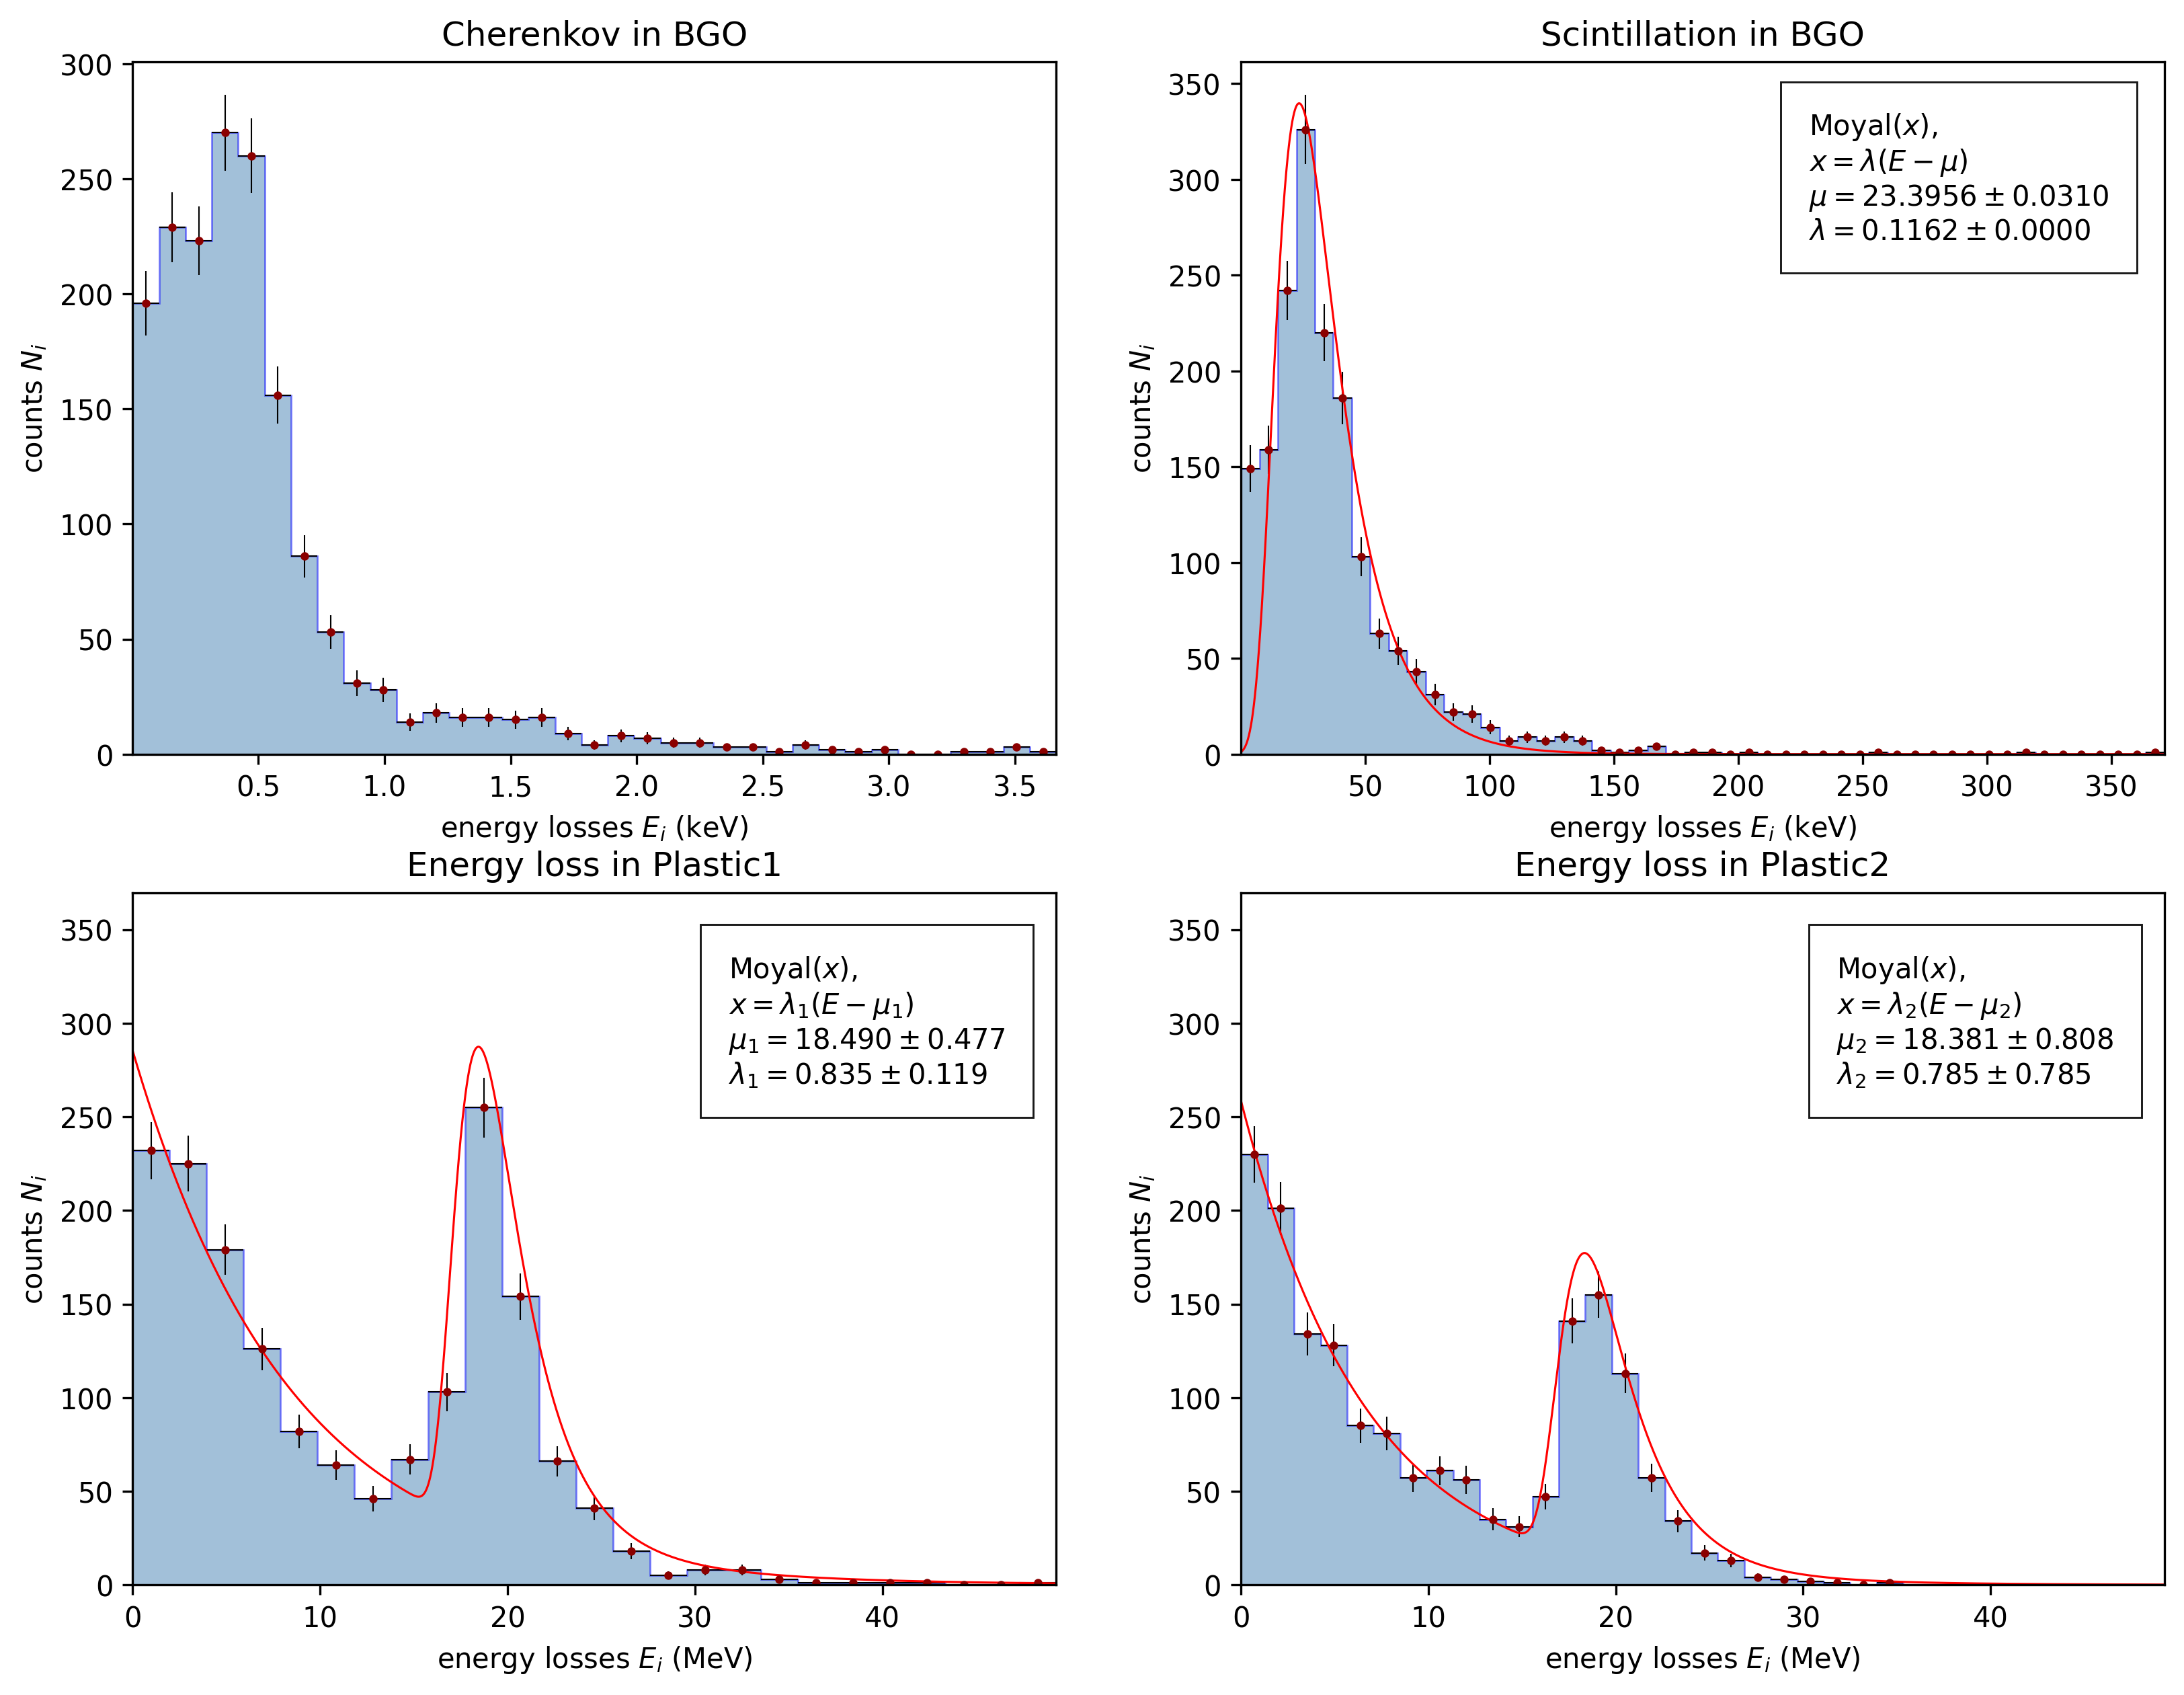

In [14]:
# prepare the figure
fig = plt.figure(111, figsize=(13,10), dpi=300)

# CERENKOV
axC = plt.subplot2grid((2, 2), (0, 0), colspan=1)
    # plot the histo
axC.hist(energyCherenkov, bins=nbinsC, label='BGO crystal', histtype="stepfilled",
        color='steelblue', ec='blue', alpha=0.5, lw=0.65, density=False)
axC.errorbar(bin_centersC, bin_heightsC, yerr=delta_bin_heightsC, xerr=xerrorC,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)
    # visualize
plt.title('Cherenkov in BGO')
plt.xlabel('energy losses $E_i$ (keV)')
plt.xlim(min(energyCherenkov), max(energyCherenkov))
plt.ylabel('counts $N_i$')

# SCINITILLATION
axS = plt.subplot2grid((2, 2), (0, 1), colspan=1)
# plot the histo
axS.hist(energyScintillation, bins=nbinsS, label='BGO crystal', histtype="stepfilled",
        color='steelblue', ec='blue', alpha=0.5, lw=0.65, density=False)
axS.errorbar(bin_centersS, bin_heightsS, yerr=delta_bin_heightsS, xerr=xerrorS,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)
    # plot the fitted function
axS.plot(energy_samplesS, landau_samplesS, label='Landau distribution', lw=0.75, alpha=1, color="red")
    # visualize
plt.title('Scintillation in BGO')
plt.xlabel('energy losses $E_i$ (keV)')
plt.xlim(min(energyScintillation), max(energyScintillation))
plt.ylabel('counts $N_i$')
plt.text(min(energyScintillation)+0.615*(max(energyScintillation)-min(energyScintillation)), max(bin_heightsScintillation)*0.8,
         'Moyal$(x)$,\n$x = \lambda(E-\mu)$\n$\mu={0:.4f} \pm {1:.4f}$\n$\lambda = {2:.4f} \pm {3:.4f}$'.format(mean_energyScintillation, covariance_Scintillation[0][0], form_Scintillation, covariance_Scintillation[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})

# Plastic scintillator 1
ax1 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
ax1.hist(energyScint1, bins=number_bins, label='Plastic1', histtype="stepfilled",
         color="steelblue", ec="blue", alpha=0.5, lw=0.65, density=False)
ax1.errorbar(bin_centers_1, bin_heights_1, yerr=delta_bin_heights_1, xerr=xerror1,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)
ax1.plot(energy_samplesP, landauExp_samples1, label= 'Fitted1', lw=0.75, alpha=1, color="red")
plt.title("Energy loss in Plastic1")
plt.xlabel('energy losses $E_i$ (MeV)')
plt.ylabel('counts $N_i$')
plt.xlim(0,max(max(energyScint1),max(energyScint2)))
plt.ylim(0,max( max(bin_heights_1),max(bin_heights_2) )*1.45)
plt.text(min(energyScint1)+0.645*(max(energyScint1)-min(energyScint1)), max(max(bin_heights_1),max(bin_heights_2))*1.05,
         'Moyal$(x)$,\n$x = \lambda_1(E-\mu_1)$\n$\mu_1={0:.3f} \pm {1:.3f}$\n$\lambda_1 = {2:.3f} \pm {3:.3f}$'.format(
             mean_energy1, covariance_1[0][0], form_1, covariance_1[1][1],mean_energy2, covariance_2[0][0], form_2, covariance_2[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})

# Plastic scintillator 2
ax2 = plt.subplot2grid((2, 2), (1, 1), colspan=1)
ax2.hist(energyScint2, bins=number_bins, label='Plastic2', histtype="stepfilled",
         color="steelblue", ec="blue", alpha=0.5, lw=0.65, density=False)
ax2.errorbar(bin_centers_2, bin_heights_2, yerr=delta_bin_heights_2, xerr=xerror2,
             marker='o', markersize=2, color="darkred", ecolor="black", lw=0, elinewidth=0.5)
ax2.plot(energy_samplesP, landauExp_samples2, label= 'Fitted2', lw=0.75, alpha=1, color="red")
plt.title("Energy loss in Plastic2")
plt.xlabel('energy losses $E_i$ (MeV)')
plt.ylabel('counts $N_i$')
plt.xlim(0,max(max(energyScint1),max(energyScint2)))
plt.ylim(0,max( max(bin_heights_1),max(bin_heights_2) )*1.45)
plt.text(min(energyScint1)+0.645*(max(energyScint1)-min(energyScint1)), max(max(bin_heights_1),max(bin_heights_2))*1.05,
         'Moyal$(x)$,\n$x = \lambda_2(E-\mu_2)$\n$\mu_2={4:.3f} \pm {5:.3f}$\n$\lambda_2 = {6:.3f} \pm {6:.3f}$'.format(
             mean_energy1, covariance_1[0][0], form_1, covariance_1[1][1],mean_energy2, covariance_2[0][0], form_2, covariance_2[1][1]),
         bbox={'facecolor': 'white', 'alpha': 0.9, 'lw': 0.7, 'pad': 10})

# end
plt.show()
fig.savefig("Unified.jpg",bbox_inches='tight')

## Derive conversion factor energy (simulation) - charge (lab)
Here we impose the equivalence of two different Landau distributions of scintillation signal:
- The first comes from the simulation, and it is a function of the total energy (in $keV$) of the scintillation photons incoming in the PMT for an event;
- The other is the one in the lab, in which we have landau as a function of the total area (in $mV \cdot ns$) of the signal;
In this way, we want to derive a conversion factor between the energy of the incoming muon and the charge of the signal.

In [15]:
# Lambda in lab (figure 3.4, scintillation)
mode_lab = 1.522e4
delta_mode_lab = 6.954e1

# same in simulation
mode_sim = mean_energyScintillation
delta_mode_sim = covariance_Scintillation[0][0]

Moyal function at its max (x=0 for both, E and Q are the values on $x$ such that we have max):
$$p_{SIM}(x) = \frac{1}{\sqrt{2\pi}} \exp \left(\frac{\lambda E+e^{\lambda E}}{2} \right)$$
$$p_{LAB}(x) = \frac{1}{\sqrt{2\pi}} \exp \left(\frac{\alpha Q+e^{\alpha Q}}{2} \right)$$
we want to impose maximum at the same point, so $\lambda E = \alpha Q$, so we can derive a first estimate of conversion factor between the maxima.
$$ E = f_{QtoE} \cdot Q$$

In [16]:
# calculate factor
fqe = mode_sim / mode_lab
delta_fqe = fqe * np.sqrt( (delta_mode_sim/mode_sim)*(delta_mode_sim/mode_sim)
                          + (delta_mode_lab/mode_lab)*(delta_mode_lab/mode_lab) )

# print result
print('f(QtoE) = {:e}'.format(fqe) + ' +/- {:e}'.format(delta_fqe) + '  keV/ns/mV')

f(QtoE) = 1.537163e-03 +/- 7.311996e-06  keV/ns/mV
